In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


In [4]:
# 1. 데이터 불러오기
train_df = pd.read_csv("./archive/train_data.csv")
test_df = pd.read_csv("./archive/test_data.csv")
weekly_forecast_df = pd.read_csv("./archive/weekly pre-dispatch forecast.csv")

# 2. 날짜 형식 변환
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])
weekly_forecast_df["datetime"] = pd.to_datetime(weekly_forecast_df["datetime"], format="%m/%d/%Y %H:%M") ## 여기서 유닉스타임으로 변경

In [5]:
# 3. 주간 예측 데이터와 테스트 데이터를 병합
merged_df = test_df.merge(weekly_forecast_df, on="datetime", how="left")

## 테스트데이터와 따로 보아야함 병합 불필요

In [6]:
# 4. 사전 예측 성능 평가
mae_official = mean_absolute_error(merged_df["DEMAND"], merged_df["load_forecast"])
rmse_official = np.sqrt(mean_squared_error(merged_df["DEMAND"], merged_df["load_forecast"]))

print(f"Pre-dispatch (사전 예측) - MAE: {mae_official:.2f}, RMSE: {rmse_official:.2f}")


Official Forecast (공식 예측) - MAE: 59.20, RMSE: 74.03


In [7]:
# 5. XGBoost 예측 모델 구축
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", 
            "weekend", "holiday", "Holiday_ID", "hourOfDay", "T2M_toc"]
target = "DEMAND"

X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
# 6. 검증 데이터 성능 평가
y_pred_xgb = xgb_model.predict(X_valid)
mae_xgb = mean_absolute_error(y_valid, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f"XGBoost Validation (XGBoost 모델 검증 성능) - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


XGBoost Validation (XGBoost 모델 검증 성능) - MAE: 37.98, RMSE: 50.95


In [9]:
# 7. 테스트 데이터 예측 및 성능 비교
test_df["xgb_pred"] = xgb_model.predict(test_df[features])

mae_xgb_test = mean_absolute_error(test_df["DEMAND"], test_df["xgb_pred"])
rmse_xgb_test = np.sqrt(mean_squared_error(test_df["DEMAND"], test_df["xgb_pred"]))

print(f"XGBoost Test - MAE: {mae_xgb_test:.2f}, RMSE: {rmse_xgb_test:.2f}")

XGBoost Test - MAE: 43.63, RMSE: 54.66


In [12]:
# 8. 비교 결과 출력
print("성능 비교:")
print(f"사전 예측 - MAE: {mae_official:.2f}, RMSE: {rmse_official:.2f}")
print(f"XGBoost Model - MAE: {mae_xgb_test:.2f}, RMSE: {rmse_xgb_test:.2f}")

성능 비교:
공식 예측 - MAE: 59.20, RMSE: 74.03
XGBoost Model - MAE: 43.63, RMSE: 54.66


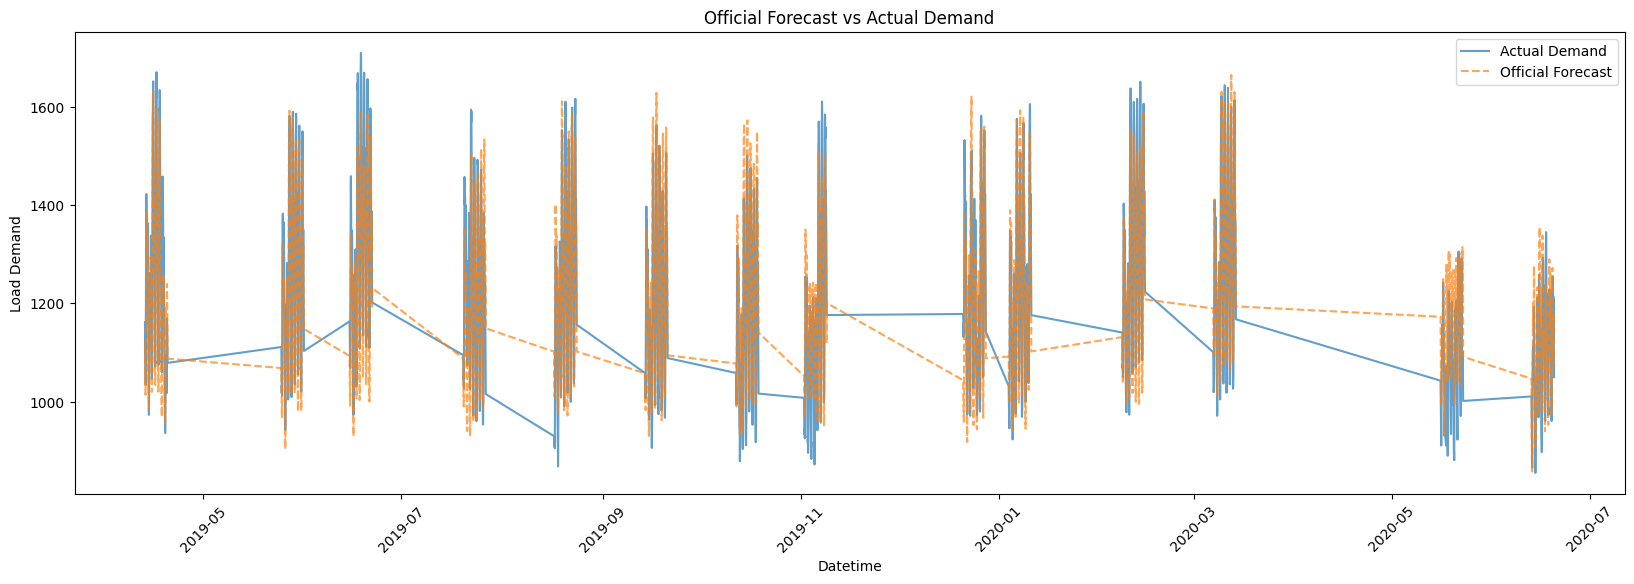

In [10]:
import matplotlib.pyplot as plt
import numpy as np

#  1. 사전 예측 vs 실제 부하 비교 시각화 (시간에 따른 변화)
plt.figure(figsize=(20, 6))
plt.plot(merged_df["datetime"], merged_df["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(merged_df["datetime"], merged_df["load_forecast"], label="Official Forecast", linestyle="--", alpha=0.7)
plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("Official Forecast vs Actual Demand")
plt.legend()
plt.xticks(rotation=45)
plt.show()


x축 설정 잘못된듯 -> 달이 넘어갈때 0731 ~ 0801 이때 공백생김
유닉스 시간으로 정수로 취급해서 나타내야함
파이썬 datetime time
한시간 단위로 변경
날짜를 유닉스 시간으로 바꾸는 전처리 필요, 시각화할땐 유닉스시간 변환해서 실제 날짜로 표기하기

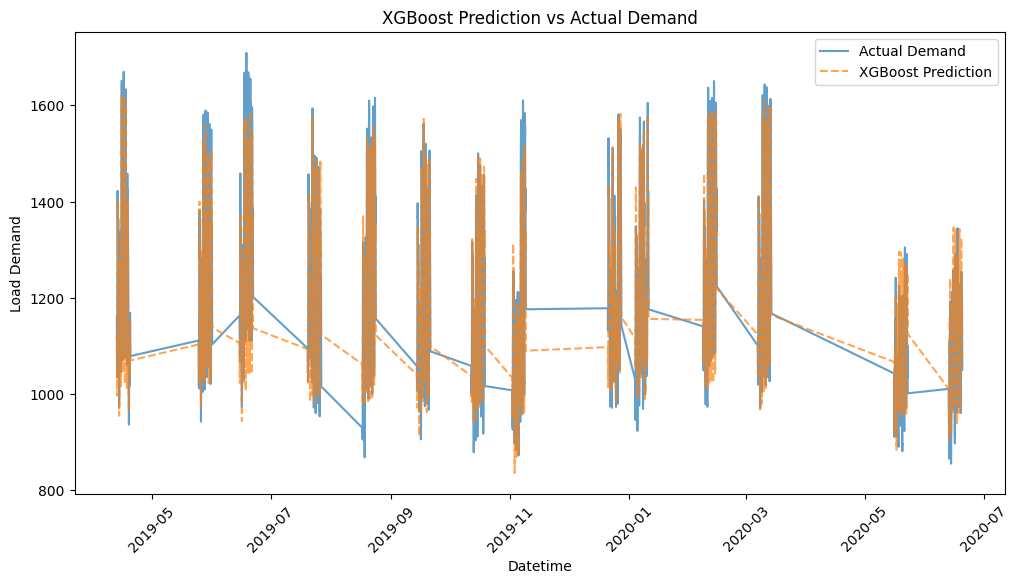

In [14]:
#  2. XGBoost 예측 vs 실제 부하 비교 (시간에 따른 변화)
plt.figure(figsize=(12, 6))
plt.plot(test_df["datetime"], test_df["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(test_df["datetime"], test_df["xgb_pred"], label="XGBoost Prediction", linestyle="--", alpha=0.7)
plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("XGBoost Prediction vs Actual Demand")
plt.legend()
plt.xticks(rotation=45)
plt.show()


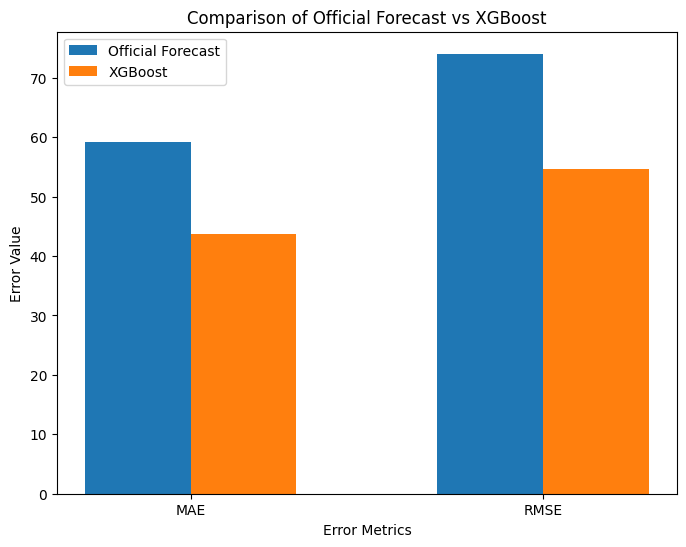

In [15]:
#  3. 모델별 오차 비교 (MAE, RMSE)
metrics = ["MAE", "RMSE"]
official_errors = [mae_official, rmse_official]
xgb_errors = [mae_xgb_test, rmse_xgb_test]

plt.figure(figsize=(8, 6))
x = np.arange(len(metrics))
width = 0.3

plt.bar(x - width/2, official_errors, width, label="Official Forecast")
plt.bar(x + width/2, xgb_errors, width, label="XGBoost")

plt.xlabel("Error Metrics")
plt.ylabel("Error Value")
plt.title("Comparison of Official Forecast vs XGBoost")
plt.xticks(ticks=x, labels=metrics)
plt.legend()
plt.show()

논문에 Evaluation metrics 다 해보고 이겨보기

🛑🛑🛑 성능 개선위해 🛑🛑🛑

(1) 시간대별 오차 분석 -> 피크 타임 (출퇴근시간) 변수 추가
(2) 계절 변수 추가 (여름철, 겨울철 전력 사용량 증가에 따름)
(3) 하이퍼파라미터 튜닝  ㅁ

(1),(2)

In [16]:
import pandas as pd

#  데이터 로딩
train_df = pd.read_csv("./archive/train_data.csv")
test_df = pd.read_csv("./archive/test_data.csv")

#  datetime 컬럼 변환
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

# (1) 피크타임 변수 추가 (출퇴근 시간: 07:00-09:00, 17:00-20:00)
def define_peak_time(hour):
    return 1 if (7 <= hour <= 9) or (17 <= hour <= 20) else 0

train_df["peak_time"] = train_df["hourOfDay"].apply(define_peak_time)
test_df["peak_time"] = test_df["hourOfDay"].apply(define_peak_time)

# (2) 계절 변수 추가 (봄=0, 여름=1, 가을=2, 겨울=3)
def define_season(month):
    if month in [3, 4, 5]:  # 봄
        return 0
    elif month in [6, 7, 8]:  # 여름
        return 1
    elif month in [9, 10, 11]:  # 가을
        return 2
    else:  # 겨울 (12, 1, 2)
        return 3

train_df["season"] = train_df["datetime"].dt.month.apply(define_season)
test_df["season"] = test_df["datetime"].dt.month.apply(define_season)

#  변수가 추가된 데이터 확인
print(train_df[["datetime", "hourOfDay", "peak_time", "season"]].head())
print(test_df[["datetime", "hourOfDay", "peak_time", "season"]].head())

#  새로운 변수 포함하여 저장
train_df.to_csv("./archive/train_data_processed.csv", index=False)
test_df.to_csv("./archive/test_data_processed.csv", index=False)


             datetime  hourOfDay  peak_time  season
0 2015-01-31 01:00:00          1          0       3
1 2015-01-31 02:00:00          2          0       3
2 2015-01-31 03:00:00          3          0       3
3 2015-01-31 04:00:00          4          0       3
4 2015-01-31 05:00:00          5          0       3
             datetime  hourOfDay  peak_time  season
0 2019-04-13 01:00:00          1          0       0
1 2019-04-13 02:00:00          2          0       0
2 2019-04-13 03:00:00          3          0       0
3 2019-04-13 04:00:00          4          0       0
4 2019-04-13 05:00:00          5          0       0


holiday 는 출퇴근 변수 관여x

train_data_processed.csv
test_data_processed.csv 
전처리된 데이터들 저장

(3) 하이퍼 파라미터 튜닝

## 논문의 하이퍼파라미터 

In [4]:
## GridSearchCV 하이퍼파라미터 튜닝

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

#  데이터 로딩
train_df = pd.read_csv("./archive/train_data_processed.csv")

#  피처 및 타겟 설정
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday",
            "Holiday_ID", "hourOfDay", "T2M_toc", "peak_time", "season"]
target = "DEMAND"

#  훈련 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

#  XGBoost 모델 정의
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)  ## random state = 123

#  하이퍼파라미터 탐색 공간 정의
param_grid = {
    "n_estimators": [100, 200, 300],  # 트리 개수
    "learning_rate": [0.01, 0.05, 0.1],  # 학습률
    "max_depth": [3, 5, 7],  # 트리 깊이
    "subsample": [0.8, 1.0],  # 데이터 샘플링 비율
    "colsample_bytree": [0.8, 1.0],  # 피처 샘플링 비율
}

#  GridSearchCV 실행 (5-fold cross validation)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error", verbose=2, n_jobs=-1) ## scoring 을 rmse로
grid_search.fit(X_train, y_train)

#  최적 하이퍼파라미터 출력
print("✅ 최적 하이퍼파라미터:", grid_search.best_params_)

#  최적 모델 성능 평가
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_valid)

mae_xgb_tuned = mean_absolute_error(y_valid, y_pred_xgb)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f"✅ 최적 XGBoost 모델 성능 (GridSearch 튜닝 후)")
print(f"MAE: {mae_xgb_tuned:.2f}")
print(f"RMSE: {rmse_xgb_tuned:.2f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END 

In [5]:
import pandas as pd

#  테스트 데이터 불러오기
test_df = pd.read_csv("./archive/test_data_processed.csv")

#  테스트 데이터에서 예측 수행
y_test_pred_xgb = best_xgb.predict(test_df[features])

#  테스트 데이터 성능 평가
mae_xgb_test = mean_absolute_error(test_df["DEMAND"], y_test_pred_xgb)
rmse_xgb_test = np.sqrt(mean_squared_error(test_df["DEMAND"], y_test_pred_xgb))

print(f"✅ 최적 XGBoost 모델 성능 (테스트 데이터)")
print(f"MAE (테스트): {mae_xgb_test:.2f}")
print(f"RMSE (테스트): {rmse_xgb_test:.2f}")


✅ 최적 XGBoost 모델 성능 (테스트 데이터)
MAE (테스트): 33.67
RMSE (테스트): 44.15


In [18]:
# Optuna 하이퍼파라미터 튜닝

import optuna
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

#  데이터 로딩
train_df = pd.read_csv("./archive/train_data_processed.csv")

#  피처 및 타겟 설정
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday",
            "Holiday_ID", "hourOfDay", "T2M_toc", "peak_time", "season"]
target = "DEMAND"

#  훈련 데이터 분리
# X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

#  Optuna 최적화 함수
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    }
    
    model = XGBRegressor(**params, objective="reg:squarederror", random_state=42)  ## randomstate 123으로
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

#  Optuna 실행 (30번 반복 탐색)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

#  최적 하이퍼파라미터 출력
print("✅ 최적 하이퍼파라미터:", study.best_params)

#  최적 모델로 성능 평가
best_xgb = XGBRegressor(**study.best_params, objective="reg:squarederror", random_state=42) ## random state = 123
best_xgb.fit(X_train, y_train)

y_pred_xgb = best_xgb.predict(X_valid)

mae_xgb_optuna = mean_absolute_error(y_valid, y_pred_xgb)
rmse_xgb_optuna = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f"✅ Optuna 최적 XGBoost 모델 성능")
print(f"MAE: {mae_xgb_optuna:.2f}")
print(f"RMSE: {rmse_xgb_optuna:.2f}")


/Users/jeonjunhyeok/Desktop/Lab/ML/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-07 22:16:42,155] A new study created in memory with name: no-name-766c3e91-9f90-4aa9-b537-72e2d4a80063
/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_33977/3350768654.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
[I 2025-03-07 22:16:45,831] Trial 0 finished with value: 28.67833344137286 and parameters: {'n_estimators': 350, 'learning_rate': 0.04921447552831815, 'max_depth': 8, 'subsample': 0.916816499305352, 'colsample_bytree': 0.6306656449963194}. Best is tri

✅ 최적 하이퍼파라미터: {'n_estimators': 300, 'learning_rate': 0.19990783912032414, 'max_depth': 10, 'subsample': 0.6838258589913246, 'colsample_bytree': 0.8283144331909364}
✅ Optuna 최적 XGBoost 모델 성능
MAE: 7.02
RMSE: 11.02


optuna 여러번해야함 서로다른 seed로 20~30회 실행 -> 다른방법과 비교(t-test)
one-sample t-test, paired t-test
--> t-test 하면 p-value 나오는데 0.05 보다 작게나오면 차이가 유의미
box plot 박스플롯

In [19]:
#  테스트 데이터 로딩
test_df = pd.read_csv("./archive/test_data_processed.csv")

#  Optuna 최적 모델로 테스트 데이터 예측
test_df["xgb_optuna_pred"] = best_xgb.predict(test_df[features])

#  테스트 데이터 성능 평가
mae_xgb_test = mean_absolute_error(test_df["DEMAND"], test_df["xgb_optuna_pred"])
rmse_xgb_test = np.sqrt(mean_squared_error(test_df["DEMAND"], test_df["xgb_optuna_pred"]))

print(f"✅ Optuna 최적 모델 성능 (테스트 데이터)")
print(f"MAE (테스트): {mae_xgb_test:.2f}")
print(f"RMSE (테스트): {rmse_xgb_test:.2f}")


✅ Optuna 최적 모델 성능 (테스트 데이터)
MAE (테스트): 14.59
RMSE (테스트): 26.29


🛑 Optuna 에서 너무 과도하게 좋은 성능이 나온것으로 보아 과적합 문제가 일어난듯 하여
max_depth 감소, learning_rate 감소, 정규화 추가를 진행하여
과적합 해결 시도

In [18]:
import optuna
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


#  데이터 로딩
train_df = pd.read_csv("./archive/train_data_processed.csv")

#  피처 및 타겟 설정
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday",
            "Holiday_ID", "hourOfDay", "T2M_toc", "peak_time", "season"]
target = "DEMAND"

#  훈련 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

#  Optuna 최적화 함수
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),  # 학습률 0.2 -> 0.15 감소
        "max_depth": trial.suggest_int("max_depth", 5, 7),                            # 10에서 5, 7 로 감소
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),  # 정규화 추가
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),  # 정규화 추가
    }
    
    model = XGBRegressor(**params, objective="reg:squarederror", random_state=42)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

####  Optuna 실행 (30번 반복 탐색)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

#  최적 하이퍼파라미터 출력
print("✅ 과적합 해결을 위한 최적 하이퍼파라미터:", study.best_params)

#  최적 모델로 성능 평가
best_xgb = XGBRegressor(**study.best_params, objective="reg:squarederror", random_state=42)
best_xgb.fit(X_train, y_train)

y_pred_xgb = best_xgb.predict(X_valid)

mae_xgb_optuna_fixed = mean_absolute_error(y_valid, y_pred_xgb)
rmse_xgb_optuna_fixed = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f"✅ 과적합 해결 후 최적 XGBoost 모델 성능")
print(f"MAE: {mae_xgb_optuna_fixed:.2f}")
print(f"RMSE: {rmse_xgb_optuna_fixed:.2f}")


/Users/jeonjunhyeok/Desktop/Lab/ML/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-17 13:17:17,856] A new study created in memory with name: no-name-e8d7c95c-aecd-42ad-bd4e-1f190da1431a
[I 2025-03-17 13:17:20,774] Trial 0 finished with value: 32.73835718002497 and parameters: {'n_estimators': 350, 'learning_rate': 0.06295009681166752, 'max_depth': 6, 'subsample': 0.8981859019913456, 'colsample_bytree': 0.9489525315396039, 'reg_lambda': 0.005792272061630845, 'reg_alpha': 0.018520082030985575}. Best is trial 0 with value: 32.73835718002497.
[I 2025-03-17 13:17:23,460] Trial 1 finished with value: 36.14274791902355 and parameters: {'n_estimators': 400, 'learning_rate': 0.032944719635260626, 'max_depth': 5, 'subsample': 0.8522289350502376, 'colsample_bytree': 0.8310583674332183, 'reg_lambda'

✅ 과적합 해결을 위한 최적 하이퍼파라미터: {'n_estimators': 500, 'learning_rate': 0.14744502513599717, 'max_depth': 7, 'subsample': 0.7064985406961457, 'colsample_bytree': 0.8059510389053872, 'reg_lambda': 0.02987086912798745, 'reg_alpha': 0.0010256366199095327}
✅ 과적합 해결 후 최적 XGBoost 모델 성능
MAE: 21.70
RMSE: 29.13


In [19]:
#  테스트 데이터 로딩
test_df = pd.read_csv("./archive/test_data_processed.csv")

#  과적합 해결된 최적 모델로 테스트 데이터 예측
test_df["xgb_optuna_fixed_pred"] = best_xgb.predict(test_df[features])

#  테스트 데이터 성능 평가
mae_xgb_test_fixed = mean_absolute_error(test_df["DEMAND"], test_df["xgb_optuna_fixed_pred"])
rmse_xgb_test_fixed = np.sqrt(mean_squared_error(test_df["DEMAND"], test_df["xgb_optuna_fixed_pred"]))

print(f"✅ 과적합 해결 후 최적 모델 성능 (테스트 데이터)")
print(f"MAE (테스트): {mae_xgb_test_fixed:.2f}")
print(f"RMSE (테스트): {rmse_xgb_test_fixed:.2f}")


✅ 과적합 해결 후 최적 모델 성능 (테스트 데이터)
MAE (테스트): 28.24
RMSE (테스트): 38.85


성능 비교:
공식 예측 - MAE: 59.20, RMSE: 74.03
XGBoost Model - MAE: 43.63, RMSE: 54.66
GridSearch 튜닝 - MAE : 33.67, RMSE : 44.15
Optuna 튜닝 - MAE: 30.36, RMSE: 40.70

In [20]:
import joblib

#  최적 모델 저장
joblib.dump(best_xgb, "./archive/final_xgb_model.pkl")
print("최종 모델 저장 완료! (./archive/final_xgb_model.pkl)")


최종 모델 저장 완료! (./archive/final_xgb_model.pkl)


In [21]:
# 🔹 최종 예측 결과 CSV 저장
test_df[["datetime", "DEMAND", "xgb_optuna_fixed_pred"]].to_csv("./archive/final_predictions.csv", index=False)
print("최종 예측 결과 저장 완료! (./archive/final_predictions.csv)")


최종 예측 결과 저장 완료! (./archive/final_predictions.csv)


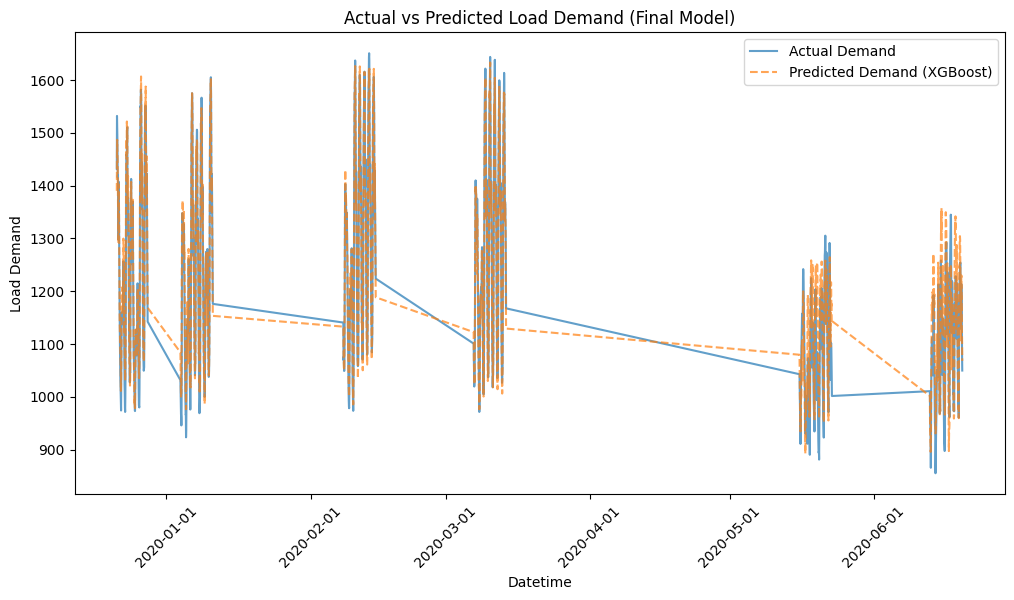

In [20]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


#  저장된 데이터 불러오기
test_df = pd.read_csv("./archive/final_predictions.csv")

#  저장된 모델 불러오기
best_xgb = joblib.load("./archive/final_xgb_model.pkl")

# datetime 컬럼을 datetime 형식으로 변환
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

# X축 범위를 줄여 확대 효과 적용 (마지막 1000개 데이터만 시각화)
test_df_zoomed = test_df.iloc[-1000:, :]

#  시각화: 실제 부하 vs 최종 예측값 비교 (시간 흐름에 따른 변화)
plt.figure(figsize=(12, 6))
plt.plot(test_df_zoomed["datetime"], test_df_zoomed["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(test_df_zoomed["datetime"], test_df_zoomed["xgb_optuna_fixed_pred"], label="Predicted Demand (XGBoost)", linestyle="--", alpha=0.7)
# X축 포맷 및 간격 조정
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("Actual vs Predicted Load Demand (Final Model)")
plt.legend()
plt.xticks()
plt.show()


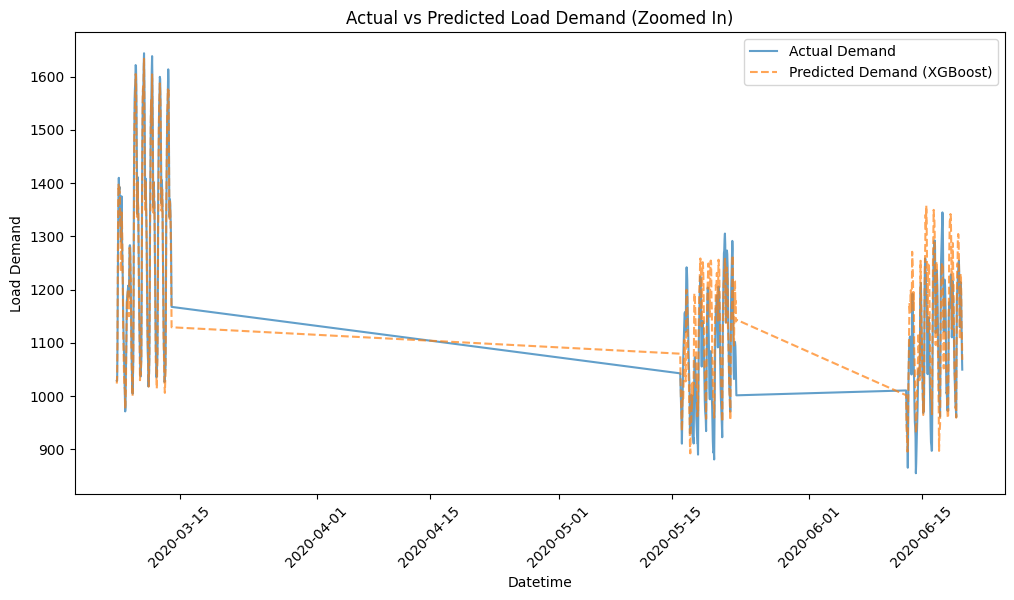

In [26]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#  저장된 데이터 불러오기
test_df = pd.read_csv("./archive/final_predictions.csv")

#  저장된 모델 불러오기
best_xgb = joblib.load("./archive/final_xgb_model.pkl")

# datetime 컬럼을 datetime 형식으로 변환
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

# X축 범위를 줄여 확대 효과 적용 (마지막 500개 데이터만 시각화)
test_df_zoomed = test_df.iloc[-500:, :]

#  시각화: 실제 부하 vs 최종 예측값 비교 (시간 흐름에 따른 변화)
plt.figure(figsize=(12, 6))
plt.plot(test_df_zoomed["datetime"], test_df_zoomed["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(test_df_zoomed["datetime"], test_df_zoomed["xgb_optuna_fixed_pred"], label="Predicted Demand (XGBoost)", linestyle="--", alpha=0.7)

# X축 포맷 및 간격 조정
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("Actual vs Predicted Load Demand")
plt.legend()
plt.show()


/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_11002/3175763692.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_df = test_df.set_index("datetime").resample("H").interpolate().reset_index()
/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_11002/3175763692.py:34: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M')


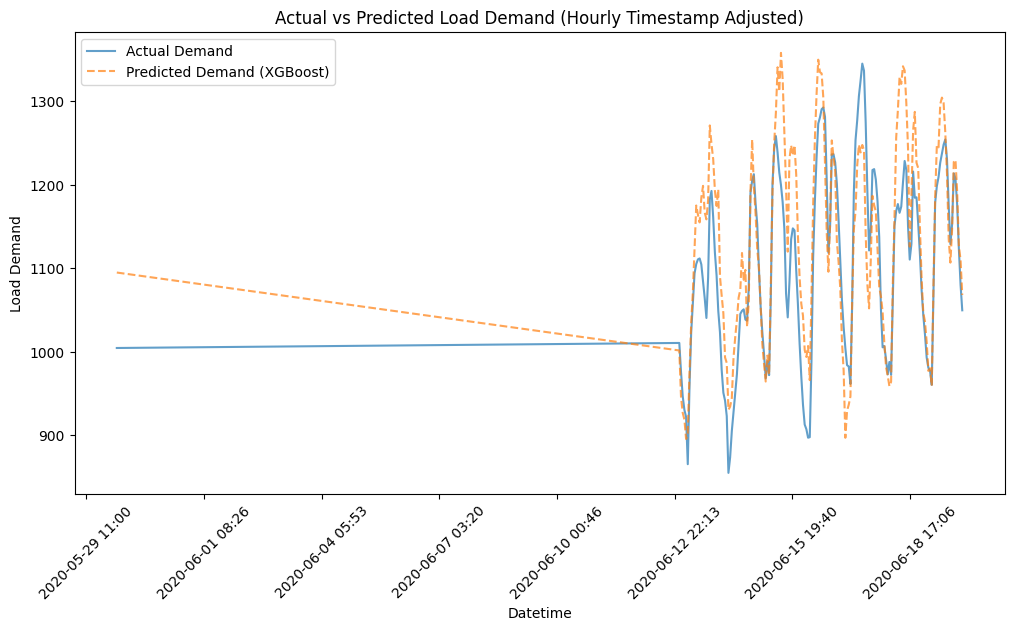

In [12]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import FuncFormatter

#  저장된 데이터 불러오기
train_df = pd.read_csv("./archive/train_data.csv")
test_df = pd.read_csv("./archive/final_predictions.csv")

#  저장된 모델 불러오기
best_xgb = joblib.load("./archive/final_xgb_model.pkl")

# datetime 컬럼을 datetime 형식으로 변환
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

# 누락된 시간 보간 (1시간 단위로 정렬)
test_df = test_df.set_index("datetime").resample("H").interpolate().reset_index()

# Unix timestamp 변환 (초 단위)
test_df["timestamp"] = test_df["datetime"].astype(int) // 10**9

# timestamp를 기준으로 정렬
test_df = test_df.sort_values("timestamp")

#  시각화: 실제 부하 vs 최종 예측값 비교 (시간 흐름에 따른 변화)
plt.figure(figsize=(12, 6))
plt.plot(test_df_zoomed["timestamp"], test_df_zoomed["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(test_df_zoomed["timestamp"], test_df_zoomed["xgb_optuna_fixed_pred"], label="Predicted Demand (XGBoost)", linestyle="--", alpha=0.7)

# X축을 다시 날짜 형식으로 변환하여 표시
def format_timestamp(x, pos):
    return datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M')

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_timestamp))
plt.xticks(rotation=45)

plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("Actual vs Predicted Load Demand (Hourly Timestamp Adjusted)")
plt.legend()
plt.show()

In [4]:
print(test_df.columns)

Index(['datetime', 'week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'dayOfWeek',
       'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc', 'DEMAND',
       'timestamp'],
      dtype='object')


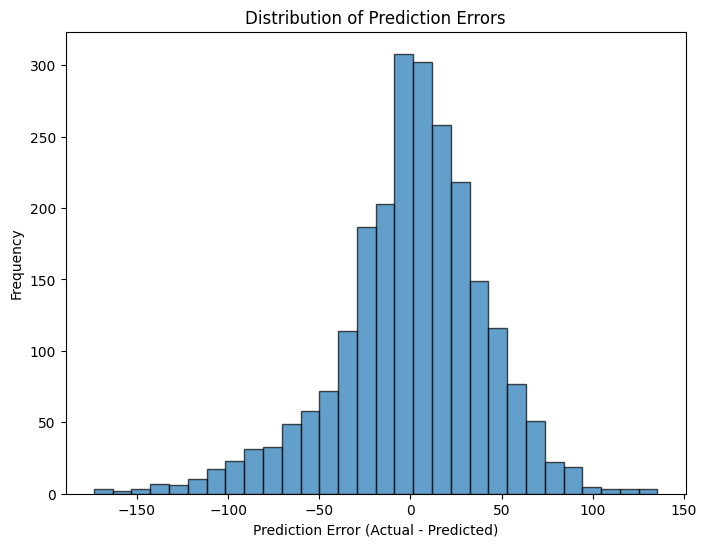

In [31]:
#  시각화: 예측 오차 분포 (히스토그램)
errors = test_df["DEMAND"] - test_df["xgb_optuna_fixed_pred"]
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [28]:
## 모델 별 성능 비교

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

#  데이터 로딩
train_df = pd.read_csv("./archive/train_data_processed.csv")
test_df = pd.read_csv("./archive/test_data_processed.csv")

#  피처 및 타겟 설정
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday",
            "Holiday_ID", "hourOfDay", "T2M_toc", "peak_time", "season"]
target = "DEMAND"

#  훈련 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

#  비교할 모델 정의
models = {
    "XGBoost": XGBRegressor(**{"n_estimators": 300, "learning_rate": 0.1, "max_depth": 7, "subsample": 0.8, "colsample_bytree": 0.8, "random_state": 42}),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42),
    "Linear Regression": LinearRegression(),
    "MLP (Neural Network)": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
}

#  모델별 학습 및 평가
results = {}

for name, model in models.items():
    print(f" Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # 성능 평가
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    results[name] = {"MAE": mae, "RMSE": rmse}

# 🔹 결과 출력
for model, metrics in results.items():
    print(f"✅ {model} - MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}")


🔹 Training XGBoost...
🔹 Training Random Forest...
🔹 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 465830, number of used features: 12
[LightGBM] [Info] Start training from score 1182.505751
🔹 Training Linear Regression...
🔹 Training MLP (Neural Network)...
✅ XGBoost - MAE: 28.80, RMSE: 38.26
✅ Random Forest - MAE: 36.86, RMSE: 49.51
✅ LightGBM - MAE: 33.41, RMSE: 44.57
✅ Linear Regression - MAE: 47.21, RMSE: 65.43
✅ MLP (Neural Network) - MAE: 37.48, RMSE: 50.51


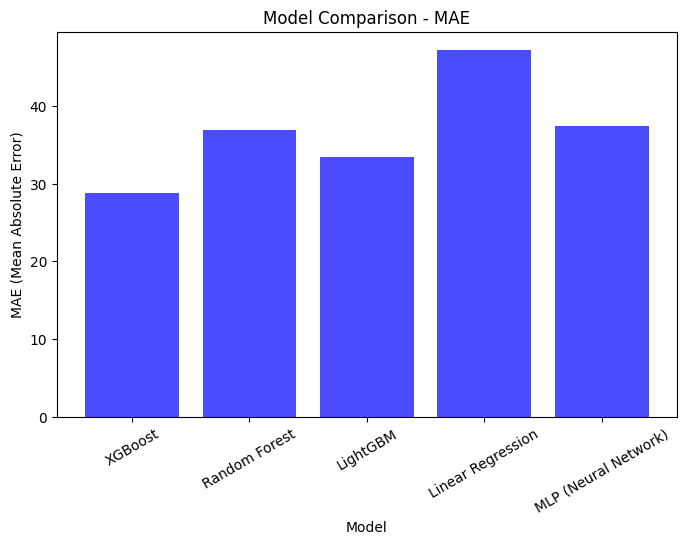

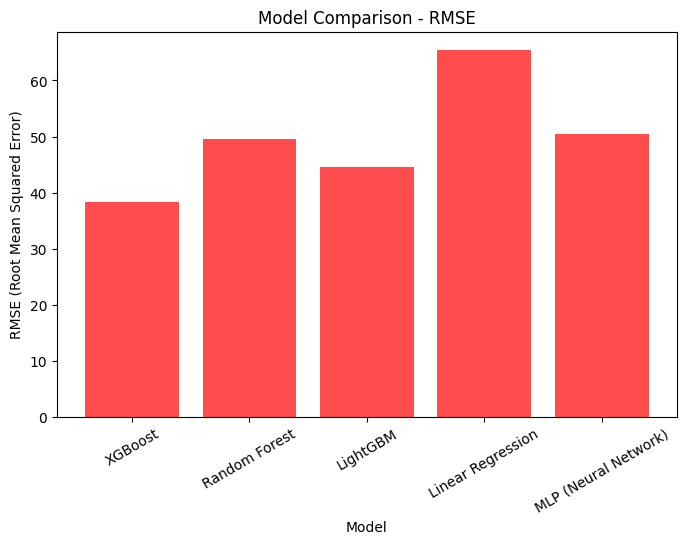

In [29]:
#  시각화: 모델별 성능 비교
mae_values = [results[model]["MAE"] for model in results]
rmse_values = [results[model]["RMSE"] for model in results]
model_names = list(results.keys())

#  MAE 비교 그래프
plt.figure(figsize=(8, 5))
plt.bar(model_names, mae_values, color="blue", alpha=0.7)
plt.xlabel("Model")
plt.ylabel("MAE (Mean Absolute Error)")
plt.title("Model Comparison - MAE")
plt.xticks(rotation=30)
plt.show()

#  RMSE 비교 그래프
plt.figure(figsize=(8, 5))
plt.bar(model_names, rmse_values, color="red", alpha=0.7)
plt.xlabel("Model")
plt.ylabel("RMSE (Root Mean Squared Error)")
plt.title("Model Comparison - RMSE")
plt.xticks(rotation=30)
plt.show()


성능 개선 방안
최근 7일 이동 평균(MA_7), 최근 14일 이동 평균(MA_14) 추가
→ 전력 사용 패턴이 일정 기간 동안 유사할 가능성이 높음

날씨 변수 추가 (기온 + 습도 + 풍속 고려한 체감 온도 포함)
→ 전력 사용량은 온도 변화뿐만 아니라 습도에도 영향을 받음

Stacking 모델 활용 (XGBoost + LGBM + RandomForest 앙상블)
→ 다양한 모델을 결합하면 더 정교한 예측 가능

시계열분석 LSTM 나중에